# Lab-12: Ensemble Learning

In this lab, we will look at different ways to build ensemble models.

## Objectives:

* Bagging
* Random Forests
* AdaBoost


Why ensemble learning? How does it help? 

## Ensemble learning
We will explore ensemble learning on the example of decision trees - we will see how ensembles can improve classification accuracy.

Let's start from uploading MNIST dataset.

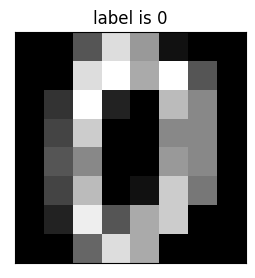

In [11]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


plt.figure(1, figsize=(3, 3))
plt.imshow(X[0].reshape((8,8)), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"label is {y[0]}")
plt.show()

### Single decision tree

First, we train a single decision tree.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print("Single tree accuracy:", tree_score)

Single tree accuracy: 0.8501683501683501


Note the accuracy - it is around **0.85**.

### Bagging

What is decreased by bagging? Variance or bias? How?

Now let's improve it a bit by the means of bagging. We train a hundred of independent classifiers and make a prediction by majority voting.

In [13]:
import numpy as np
from scipy.stats import mode

n_trees = 100

classifiers = []
for i in range(n_trees):
    # train a new classifier and append it to the list
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)
    classifiers.append(tree)

# here we will store predictions for all samples and all base classifiers
base_pred = np.zeros((X_test.shape[0], n_trees), dtype="int")
for i in range(n_trees):
    # obtain the predictions from each tree
    base_pred[:, i] = classifiers[i].predict(X_test)

for i in range(5):
    print(f'Predictions for the {i}th sample')
    sample_pred, sample_pred_count = np.unique(
        base_pred[i], return_counts=True)
    for j in range(len(sample_pred)):
        print(sample_pred_count[j], 'Trees predicted', sample_pred[j])
    print()

# aggregate predictions by majority voting
pred = mode(base_pred, axis=1)[0].reshape(-1)
acc = accuracy_score(y_test, pred)
print("Bagging accuracy:", acc)


Predictions for the 0th sample
100 Trees predicted 3

Predictions for the 1th sample
100 Trees predicted 8

Predictions for the 2th sample
100 Trees predicted 2

Predictions for the 3th sample
100 Trees predicted 6

Predictions for the 4th sample
100 Trees predicted 6

Bagging accuracy: 0.8501683501683501


C:\Users\hp\AppData\Local\Temp\ipykernel_5312\791810446.py:28: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred = mode(base_pred, axis=1)[0].reshape(-1)


Now the accuracy grew up to **0.88**. Also, you can see that our classifiers
return very similar results.

Let's compare our bagging to SKlearn

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9747474747474747

Why our performance is much lower then sklearn? 


### Random forest

Compared to the simple bagging we've just implemented, random forest can show
better results because base classifiers are much less correlated.

At first, let's implement bootstrap sampling.

In [15]:
def bootstrap(X, y):
    # generate bootstrap indices and return data according to them
    ind = np.random.randint(0, X.shape[0], X.shape[0])
    return X[ind,:], y[ind]


# this is a test, will work if you are using np.random.randint() for indices generation
np.random.seed(0)
a = np.array(range(12)).reshape(4,3)
b = np.array(range(4))
bootstrap(a, b)

(array([[ 0,  1,  2],
        [ 9, 10, 11],
        [ 3,  4,  5],
        [ 0,  1,  2]]),
 array([0, 3, 1, 0]))

You should get

(array([[ 0,  1,  2], <br>
&emsp;&emsp;&emsp;[ 9, 10, 11], <br>
&emsp;&emsp;&emsp;[ 3,  4,  5], <br>
&emsp;&emsp;&emsp;[ 0,  1,  2]]), <br>
array([0, 3, 1, 0]))

Now let's build a set of decision trees, each of them is trained on a bootstrap
sampling from X and $\sqrt d$ features.

In [16]:
classifiers = []
for i in range(n_trees):
    # train a new tree on sqrt(n_features) and bootstrapped data, append it to the list
    base = DecisionTreeClassifier(max_features="sqrt", random_state=42)
    X_train_b, y_train_b = bootstrap(X_train, y_train)
    base.fit(X_train_b, y_train_b)
    classifiers.append(base)

base_pred = np.zeros((n_trees, X_test.shape[0]), dtype="int")
for i in range(n_trees):
    base_pred[i,:] = classifiers[i].predict(X_test)

pred = mode(base_pred, axis=0)[0].ravel()
acc = accuracy_score(y_test, pred)
print("Random forest accuracy:", acc)

Random forest accuracy: 0.9814814814814815


C:\Users\hp\AppData\Local\Temp\ipykernel_5312\411566922.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred = mode(base_pred, axis=0)[0].ravel()


And now we got **0.98** accuracy, which is a significant improvement! Now you
can see why it is so important to have diverse classifiers.

---
## Boosting

How does boosting work?  

For simplicity let's solve a binary classification problem

In [17]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data['target'][data['target']==0] = -1  # turn 0s to -1 to make the calculations easier
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.2, random_state=0)

Now let's train a boosting model.

We will have sample weights and tree weights. Initially all sample weights are equal. After that we will increase weight for complicated samples.

Tree weight $w$ is computed using weighted error or $1 - accuracy$

$w_t = \frac12 log(\frac{1-weighted\_error_t}{weighted\_error_t})$ for each base classifier.

For correct samples weights will be decreased $e^w$ times, and for incorrect classified samples increased  $e^w$ times. After this changes we normalize weights.

In [18]:
n_trees = 3
tree_weights = np.zeros(n_trees)
classifiers = []
train_samples = X_train.shape[0]
# initialize sample weights
sample_weights = np.ones(train_samples) / train_samples
for i in range(n_trees):
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_train, y_train, sample_weight=sample_weights)
    pred = clf.predict(X_train)
    acc = accuracy_score(y_train, pred, sample_weight=sample_weights)
    # Calculate tree weight
    w = 0.5 * np.log((1 - acc) / acc)
    tree_weights[i] = w
    classifiers.append(clf)
    # Update sample weights
    for j in range(train_samples):
        if pred[j] != y[j]:
            sample_weights[j] = sample_weights[j] * np.exp(w)
        else:
            sample_weights[j] = sample_weights[j] * np.exp((-w))
    # normalize the weights
    sample_weights = sample_weights / np.sum(sample_weights)

Use trees voting to calculate final predictions. Since we have a binary classification, the prediction will be calculated as follows:

$\hat{y} = sign(\sum_{t=1}^{T}(w_t f_t(x)))$

In [19]:
n_test = X_test.shape[0]

pred = np.zeros(n_test)

# Aggregate the  predictions
for i in range(n_trees):
    pred += tree_weights[i] * classifiers[i].predict(X_test)
    

for i in range(n_test):
    pred[i] = 1 if pred[i] > 0 else -1


acc = accuracy_score(y_test, pred)
print("Boosting accuracy:", acc)


Boosting accuracy: 0.043859649122807015


# [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)
Sklearn has many ensemble [methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

In [20]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100
)
clf = clf.fit(X_train, y_train)
print('AdaBoost accuracy:', clf.score(X_test, y_test))


AdaBoost accuracy: 0.956140350877193
